In [31]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#os.getcwd()
debug =False

In [32]:
#Data  Path

path = 'datasets\housing\housing.csv'
housing = pd.read_csv(path)
if debug == True:
    print(housing.head())

if debug == True:
    print(housing.info())
    
if debug == True:
    print(housing.describe())

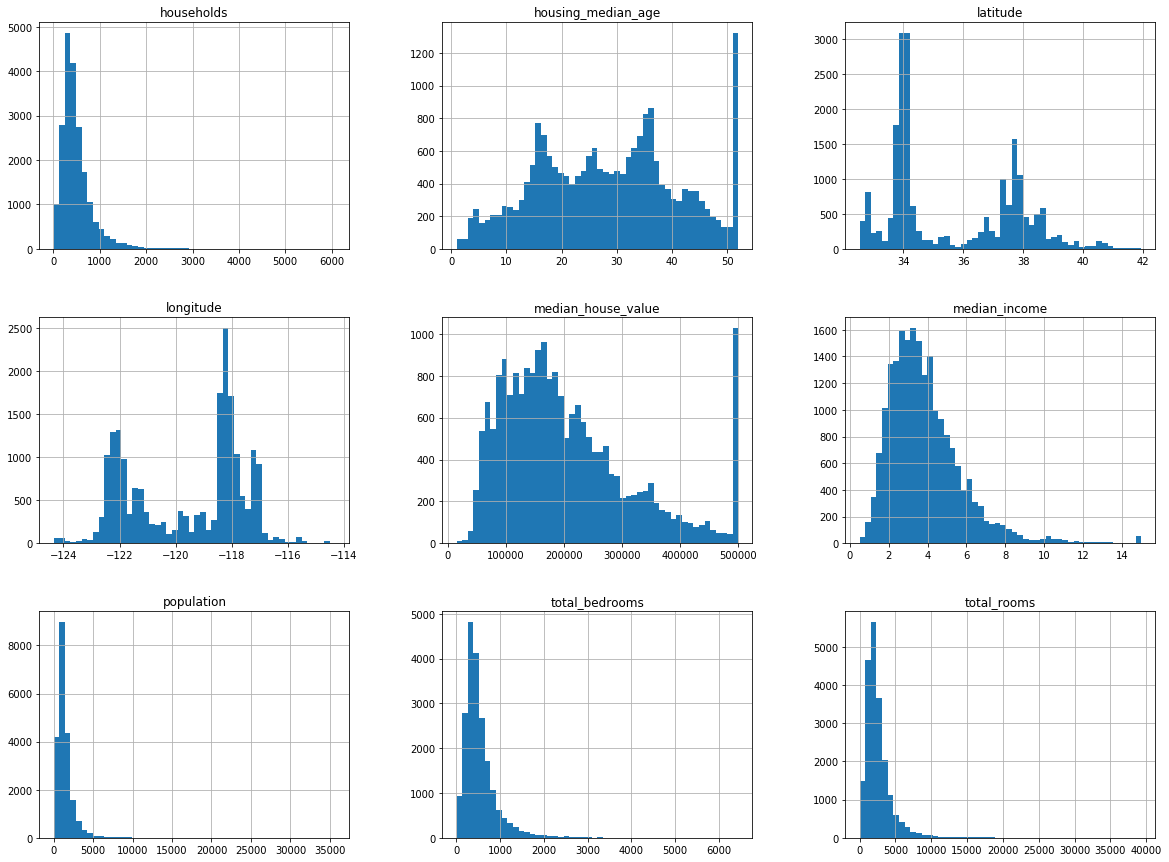

In [33]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [35]:
housing['income_cat']= np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat']<5,5.0, inplace = True)

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [37]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat', axis=1,inplace= True)

In [38]:
housing = strat_train_set.copy()

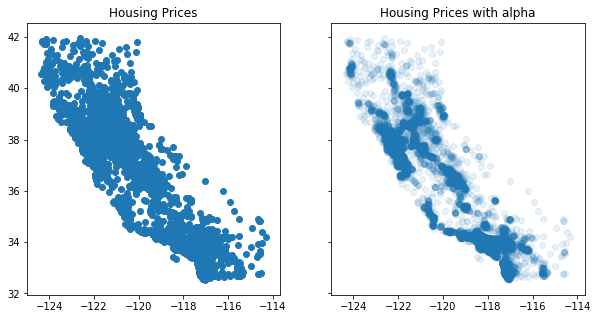

In [53]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(10,5))
ax1.scatter( x=housing['longitude'], y=housing['latitude'])
ax1.set_title('Housing Prices')
ax2.scatter(x=housing['longitude'], y=housing['latitude'], alpha =0.1)
ax2.set_title('Housing Prices with alpha')
plt.show()

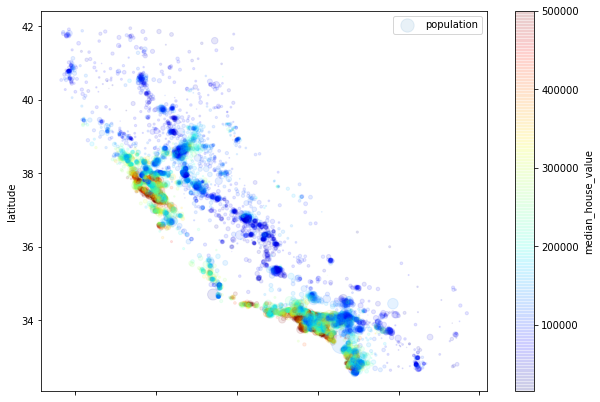

In [55]:
housing.plot(kind='scatter', x='longitude',y='latitude', alpha =0.1,
            s=housing['population']/100,label='population',figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()

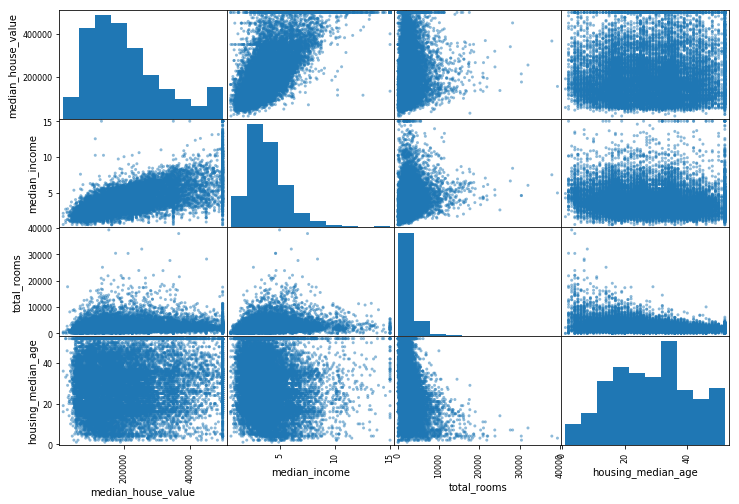

In [59]:
corr_matrix = housing.corr()
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

In [60]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room =True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,household_ix]
        population_per_household = X[:,population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X, rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household,population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [82]:
housing_num = housing.drop('ocean_proximity', axis=1)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.preprocessing import Imputer

from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [83]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrbute_names):
        self.attrbute_names= attrbute_names
    def fit(self, X,y=None):
        return self
    def transform(self,X):
        return X[self.attrbute_names].values

In [84]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])

cat_pipeline= Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer())
])

In [85]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [86]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


In [90]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [93]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                         scoring= 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(tree_rmse_scores)

[68371.57309189 66908.27794399 69568.8846677  69142.31838521
 70598.03624854 73500.72237321 68864.72012524 69936.13109566
 73722.51406699 69603.43443542]


In [97]:
from sklearn.externals import joblib
#joblib.dump(my_model, "my_model.pkl")

#my_model_loaded = joblib.load("my_model.pkl")

In [98]:
from sklearn.model_selection import GridSearchCV
param_grid =[
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

In [100]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid,cv=5,
                          scoring= 'neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [101]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [102]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [103]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

64668.235460836906 {'max_features': 2, 'n_estimators': 3}
55381.492819634805 {'max_features': 2, 'n_estimators': 10}
53181.94756999967 {'max_features': 2, 'n_estimators': 30}
60922.839195591965 {'max_features': 4, 'n_estimators': 3}
52739.28251920292 {'max_features': 4, 'n_estimators': 10}
50504.86200664808 {'max_features': 4, 'n_estimators': 30}
58978.11006306547 {'max_features': 6, 'n_estimators': 3}
52093.701630650874 {'max_features': 6, 'n_estimators': 10}
50123.51398035242 {'max_features': 6, 'n_estimators': 30}
58169.064689846615 {'max_features': 8, 'n_estimators': 3}
52166.469841011785 {'max_features': 8, 'n_estimators': 10}
50132.530295553566 {'max_features': 8, 'n_estimators': 30}
62393.49828373141 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54437.924851323485 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59605.53648489638 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52505.72851196039 {'bootstrap': False, 'max_features': 3, 'n_estimat

In [104]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.18541549e-02, 6.87838227e-02, 4.34777405e-02, 1.96496734e-02,
       1.73700999e-02, 1.94976418e-02, 1.65905845e-02, 3.42347553e-01,
       6.11121649e-02, 1.06255097e-01, 7.00301836e-02, 8.88277510e-03,
       1.46886083e-01, 7.77802021e-05, 3.46454348e-03, 3.72010180e-03])

In [105]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value',axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48124.09049528857
